#Problem Synopsis:

In this notebook, we will examine how to use Convolutional neural networks (CNNs) for image classification, recognizing hand-written digits in this instance. We will also examine how to optimize the performance of the CNNs using Callbacks.

# Library Imports

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
import numpy as np
from numpy import random
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, Callback, EarlyStopping
from keras import regularizers
from keras.optimizers import Adam

# Read Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Code Portfolio/NN - CNN Image Classification/train.csv')

In [ ]:
#Examine the first 10 rows of the dataset
df.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Examine the shape of the dataset
df.shape

(42000, 785)

In [ ]:
'''
def display_images(X, y=[], rows=5, columns=5, cmap="gray"):
    """ Display images and labels
    """
    fig, ax = plt.subplots(rows,columns, figsize=(6,6))
    for row in range(rows):
        for column in range(columns):
            ax[row][column].imshow(X[(row*columns)+column].reshape(28,28), cmap=cmap)
            ax[row][column].set_axis_off()
            if len(y):ax[row][column].set_title("{}:{}".format("label",np.argmax(y[(row*columns)+column])))
    fig.tight_layout()

%matplotlib inline
'''

# Define Helper Functions

In [ ]:
#helper function to display images from the data:

def display_images(X, y=[], rows=5, columns=5, cmap='gray'):
    '''
    Displays images and labels
    '''
    #image display:
    fig, ax = plt.subplots(rows,columns, figsize=(6,6))
    for row in range(rows):
        for column in range(columns):
            ax[row][column].imshow(X[(row*columns)+column].reshape(28,28), cmap=cmap)
            ax[row][column].set_axis_off()

            #label display for one-hot encoded labels:
            if len(y):
              ax[row][column].set_title("{}:{}".format("label",np.argmax(y[(row*columns)+column])))
    fig.tight_layout()

In [ ]:
# Define a class to record the loss at the end of every training batch, allowing us to track the loss changes throughout the training process for every model that we create

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [ ]:
#Define a function to create neural networks

def create_model():
    '''
    Creates a CNN model
    '''
    model = keras.Sequential()
    #first Convolutional Block
    model.add(keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(width, height, channels)))
    model.add(keras.layers.Conv2D(32, (5,5), padding='same', activation = 'relu'))
    model.add(keras.layers.MaxPool2D(pool_size= (2,2)))
    model.add(keras.layers.Dropout(0.4))

    #second Convolutional Block
    model.add(keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(keras.layers.Dropout(0.5))

    #flatten layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(384, activation='relu'))
    model.add(keras.layers.Dropout(0.5))

    #Prediction layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    #Optimizer:
    model.compile(loss= keras.losses.CategoricalCrossentropy, optimizer = 'adam', metrics = ['accuracy'])

    return model

In [ ]:
def plot_metrics(batch_history, title=''):
  '''
  Plot training metrics - loss and accuracy, for each epoch,
  given a training history object
  '''
  fig, axes = plt.subplots(1,2,figsize=(10,5))

  axes[0].plot(batch_history.history['loss'], color='lightblue', label='Training', lw=2.0)
  axes[0].plot(batch_history.history['val_loss'], color='steelblue', label='Validation', lw=2.0)

  axes[0].set_title('{} (Loss)'.format(title))
  axes[0].set_xlabel('Epoch')
  axes[0].set_xticks(np.arange(len(batch_history.history['loss']), 2))
  axes[0].set_ylabel('Loss')

  axes[1].plot(batch_history.history['accuracy'], color='lightblue', label='Training', lw=2.0)
  axes[1].plot(batch_history.history['val_accuracy'], color='steelblue', label='Validation', lw=2.0)

  axes[1].set_title('{} (Accuracy)'.format(title))
  axes[1].set_xlabel('Epoch')
  axes[1].set_xticks(np.arange(len(batch_history.history['accuracy']), 2))
  axes[1].set_ylabel('Loss')

  for axis in axes:
    axis.ticklabel_format(useOffset=False)
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.legend(loc='best', shadow=False)

  fig.tight_layout()

In [ ]:
def plot_losses(batch_hist, title=''):
  '''
  Plots model losses
  '''
  fig, ax1 = plt.subplots()

  ax1.semilogx(batch_hist.losses)
  ax1.set_title('{} (Batch Loss)'.format(title))

  ax1.spines['top'].set_visible(False)
  ax1.spines['right'].set_visible(False)

  plt.show()

# Data Processing

In [ ]:
# We will split our data into training, validation, and testing sets.
# The training set will be used to train the model
# The validaiton set will be used to evaluate and tune the model's performance during training
# The test set will be used to evalaute the model's performance on unseen data (out of sample performance testing)

#split data into training and validation sets:
X_train, X_val, y_train, y_val = train_test_split(df.iloc[:,1:].values, df.iloc[:,0].values, test_size = 0.4)

#split validation set into cross-validation and test sets:
X_cv, X_test, y_cv, y_test = train_test_split(X_val, y_val, test_size = 0.5)

print("X_train:{}\ny_train:{}\n\nX_cv:{}\ny_cv:{}\n\nX_test:{}\ny_test:{}".format(X_train.shape, y_train.shape, X_cv.shape, y_cv.shape, X_test.shape, y_test.shape))

X_train:(25200, 784)
y_train:(25200,)

X_cv:(8400, 784)
y_cv:(8400,)

X_test:(8400, 784)
y_test:(8400,)


In [ ]:
# The images are in .CSV format meaning they are each represented by 784 values. We will reformat the data to be 28x28, with one channel for color (one color here).
# We will also normalize the gray scale from 0-255 to be between 0-1.

#dimension parameters:
width=28
height=28
channels=1

#Reshape Input
X_train = X_train.reshape(X_train.shape[0],width, height, channels)
X_cv = X_cv.reshape(X_cv.shape[0],width, height, channels)
X_test = X_test.reshape(X_test.shape[0],width, height, channels)

#change input into floats
X_train = X_train.astype('float32')
X_cv = X_cv.astype('float32')
X_test = X_test.astype('float32')

#scale input to range[0-1]:
X_train /= 255
X_cv /= 255
X_test /= 255

#one-hot encode output labels
y_train = keras.utils.to_categorical(y_train, num_classes = 10)
y_cv = keras.utils.to_categorical(y_cv, num_classes = 10)
y_test = keras.utils.to_categorical(y_test, num_classes = 10)

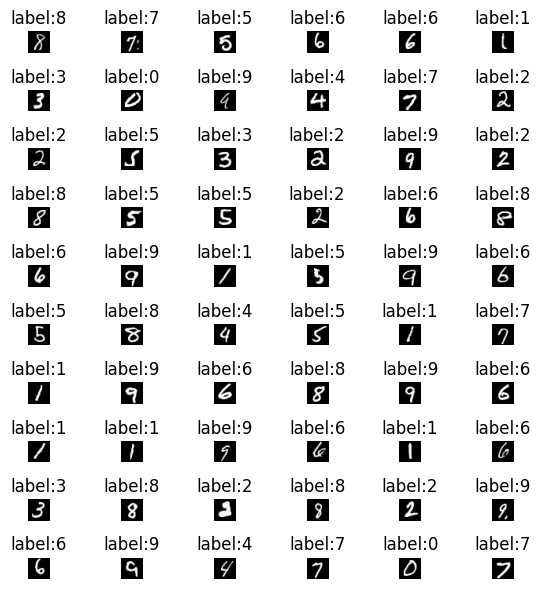

In [ ]:
#examine the first 36 images and their corresponding labels
display_images(X_train, y_train, rows = 10, columns = 6)

# Modeling

We will create multiple models with different hyperparameer tuning options. We will then observe the differnce in their performance.

In [ ]:
# define initail training parameters:
batch_size = 84
epochs = 30
verbose = 2

In [ ]:
# Create Initial Model without any hyperparamter tuning:

model0 = create_model()

model0_batch_hist = LossHistory()

model0_metrics = model0.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose, callbacks=model0_batch_hist, validation_data=(X_cv, y_cv), shuffle=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
300/300 - 10s - 35ms/step - accuracy: 0.8810 - loss: 0.3583 - val_accuracy: 0.9767 - val_loss: 0.0751
Epoch 2/30
300/300 - 1s - 4ms/step - accuracy: 0.9688 - loss: 0.1015 - val_accuracy: 0.9810 - val_loss: 0.0603
Epoch 3/30
300/300 - 1s - 4ms/step - accuracy: 0.9748 - loss: 0.0812 - val_accuracy: 0.9824 - val_loss: 0.0569
Epoch 4/30
300/300 - 1s - 4ms/step - accuracy: 0.9797 - loss: 0.0638 - val_accuracy: 0.9861 - val_loss: 0.0448
Epoch 5/30
300/300 - 1s - 4ms/step - accuracy: 0.9826 - loss: 0.0586 - val_accuracy: 0.9865 - val_loss: 0.0479
Epoch 6/30
300/300 - 1s - 4ms/step - accuracy: 0.9846 - loss: 0.0498 - val_accuracy: 0.9874 - val_loss: 0.0400
Epoch 7/30
300/300 - 1s - 4ms/step - accuracy: 0.9858 - loss: 0.0437 - val_accuracy: 0.9883 - val_loss: 0.0442
Epoch 8/30
300/300 - 1s - 4ms/step - accuracy: 0.9864 - loss: 0.0420 - val_accuracy: 0.9886 - val_loss: 0.0394
Epoch 9/30
300/300 - 1s - 4ms/step - accuracy: 0.9879 - loss: 0.0378 - val_accuracy: 0.9901 - val_loss: 0.0364

In [ ]:
# Create model with learning rate controller.
#This controller will reduce the learning rate if the model's validation accuracy doesnt improve afeter a set number of epochs (2 in this case)

#Initiate the learing rate controller:
learning_rate_controller = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=0.00001, min_delta=0.001)

#Create new model with the learning rate controller included
model1 = create_model()
model1_batch_history = LossHistory()

model1_metrics = model1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose, callbacks=[model1_batch_history, learning_rate_controller], validation_data=(X_cv, y_cv), shuffle=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
300/300 - 6s - 21ms/step - accuracy: 0.8741 - loss: 0.3776 - val_accuracy: 0.9694 - val_loss: 0.0950 - learning_rate: 1.0000e-03
Epoch 2/30
300/300 - 1s - 4ms/step - accuracy: 0.9648 - loss: 0.1118 - val_accuracy: 0.9764 - val_loss: 0.0761 - learning_rate: 1.0000e-03
Epoch 3/30
300/300 - 1s - 4ms/step - accuracy: 0.9741 - loss: 0.0847 - val_accuracy: 0.9825 - val_loss: 0.0581 - learning_rate: 1.0000e-03
Epoch 4/30
300/300 - 1s - 4ms/step - accuracy: 0.9788 - loss: 0.0685 - val_accuracy: 0.9842 - val_loss: 0.0524 - learning_rate: 1.0000e-03
Epoch 5/30
300/300 - 1s - 4ms/step - accuracy: 0.9819 - loss: 0.0592 - val_accuracy: 0.9869 - val_loss: 0.0423 - learning_rate: 1.0000e-03
Epoch 6/30
300/300 - 1s - 4ms/step - accuracy: 0.9835 - loss: 0.0526 - val_accuracy: 0.9875 - val_loss: 0.0399 - learning_rate: 1.0000e-03
Epoch 7/30
300/300 - 1s - 4ms/step - accuracy: 0.9851 - loss: 0.0492 - val_accuracy: 0.9857 - val_loss: 0.0506 - learning_rate: 1.0000e-03
Epoch 8/30
300/300 - 1s - 

In [ ]:
idg = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=False,
        vertical_flip=False, data_format="channels_last")

In [ ]:
# Create Model with Random image transformation and learning rate controller.
# Utilizing this Keras capability enables us to generate randomly modified versions of the images. These small modifications help the model generalize better.
# This helps reduce overfititng.


# Create random image generator
idg = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=False,
        vertical_flip=False, data_format="channels_last")

# Create new model including random image generator and learing rate controller
model2 = create_model()
model2_batch_hist = LossHistory()

model2_metrics = model2.fit(idg.flow(X_train, y_train, batch_size = batch_size),
                            epochs = epochs, verbose = verbose, callbacks = [model2_batch_hist, learning_rate_controller],
                            validation_data=(X_cv, y_cv), shuffle = True, steps_per_epoch= X_train.shape[0]//batch_size)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 - 15s - 51ms/step - accuracy: 0.8547 - loss: 0.4466 - val_accuracy: 0.9760 - val_loss: 0.0828 - learning_rate: 1.0000e-03
Epoch 2/30
300/300 - 7s - 23ms/step - accuracy: 0.9532 - loss: 0.1519 - val_accuracy: 0.9814 - val_loss: 0.0591 - learning_rate: 1.0000e-03
Epoch 3/30
300/300 - 7s - 24ms/step - accuracy: 0.9662 - loss: 0.1107 - val_accuracy: 0.9840 - val_loss: 0.0524 - learning_rate: 1.0000e-03
Epoch 4/30
300/300 - 7s - 24ms/step - accuracy: 0.9724 - loss: 0.0945 - val_accuracy: 0.9869 - val_loss: 0.0421 - learning_rate: 1.0000e-03
Epoch 5/30
300/300 - 8s - 25ms/step - accuracy: 0.9748 - loss: 0.0791 - val_accuracy: 0.9881 - val_loss: 0.0413 - learning_rate: 1.0000e-03
Epoch 6/30
300/300 - 7s - 24ms/step - accuracy: 0.9795 - loss: 0.0698 - val_accuracy: 0.9877 - val_loss: 0.0376 - learning_rate: 1.0000e-03
Epoch 7/30
300/300 - 7s - 24ms/step - accuracy: 0.9800 - loss: 0.0652 - val_accuracy: 0.9894 - val_loss: 0.0381 - learning_rate: 1.0000e-03
Epoch 8/30
300/300 - 8s - 25ms

#Analyze Performance

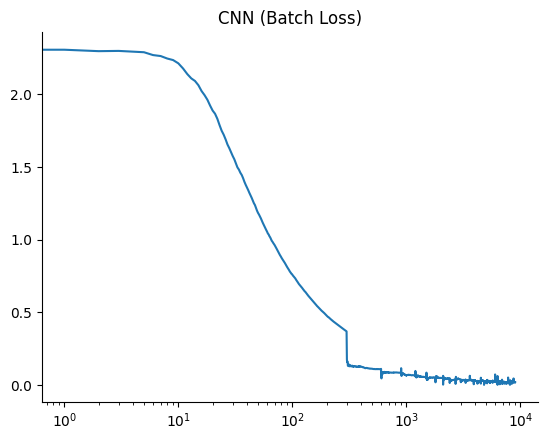

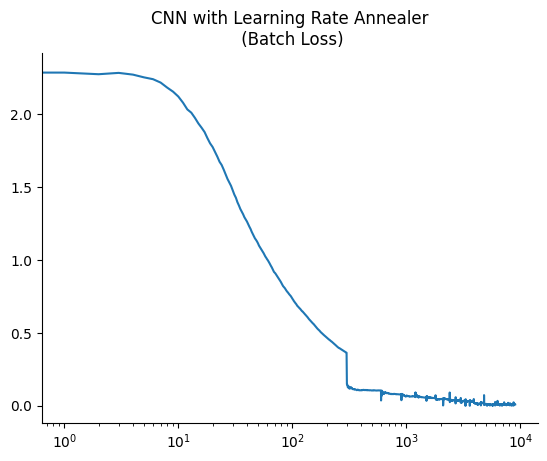

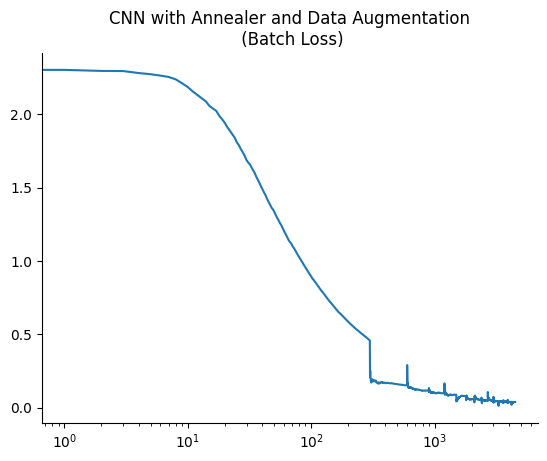

In [ ]:
# Plot the losses for each model to investigate ho
plot_losses(model0_batch_hist, 'CNN')
plot_losses(model1_batch_history, 'CNN with Learning Rate Annealer\n')
plot_losses(model2_batch_hist, 'CNN with Annealer and Data Augmentation\n')

##LOSS FUNCITONS

It appears from the loss functions plots that the learning rate annealer does reduce noise slightly. The learing rate annealer coupled with the rnadom image modifier seem to have a steeper tail indicating even further reducion in noise.

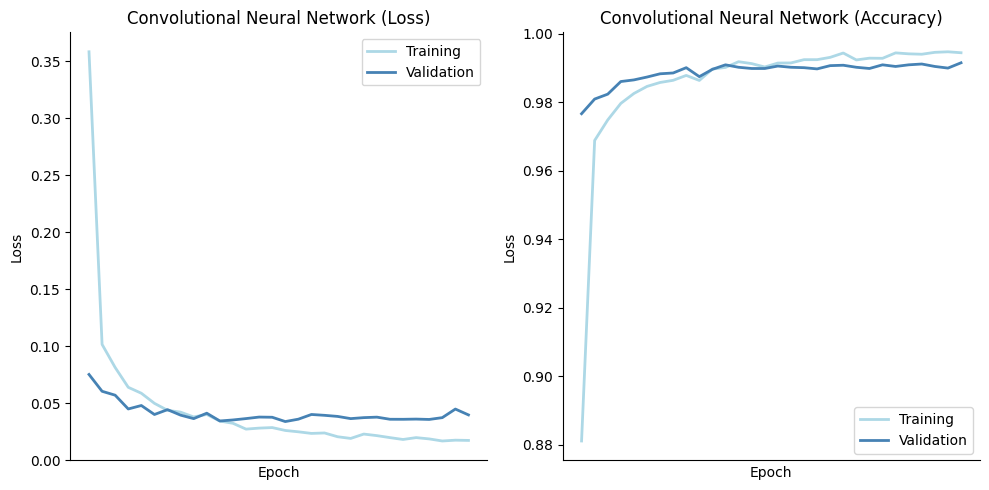

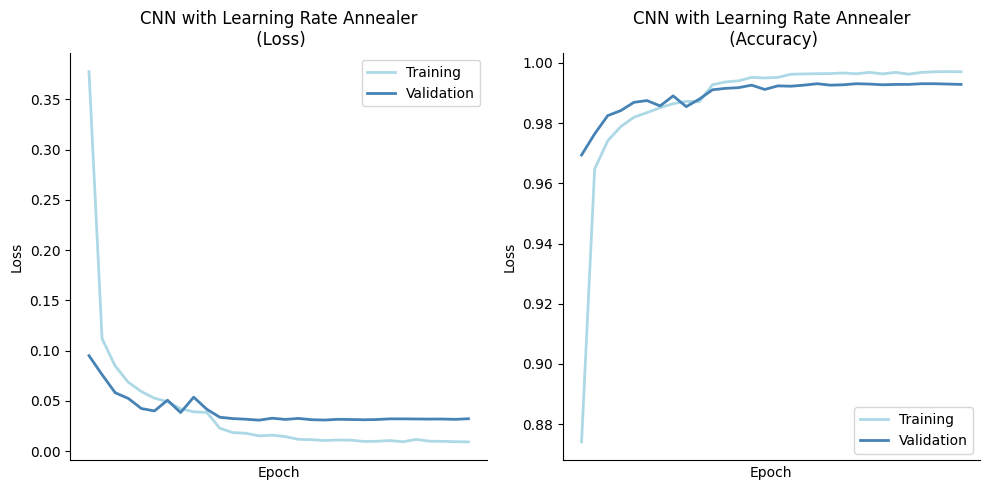

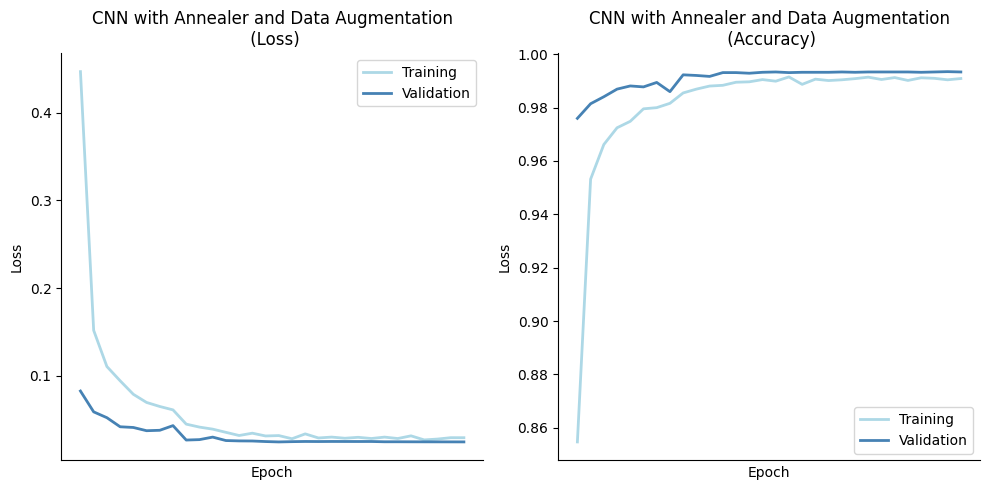

In [ ]:
#Plot the loss and accuracy for the training and validation sets for the three models
plot_metrics(model0_metrics,"Convolutional Neural Network")
plot_metrics(model1_metrics,"CNN with Learning Rate Annealer\n")
plot_metrics(model2_metrics,"CNN with Annealer and Data Augmentation\n")

##Loss and Accuracy metrics

Looking at the performane of the three models, we can see that the learning rate annealer smoothed the loss and accuracy metrics. When looking at the third model, we can see that data augmentation reduced overfitting compared to the previous models.

,Model,Training Accuracy,Validation Accuracy,Test Accuracy
0,Convolutional Neural Network,99.45,99.15,99.18
1,CNN + Learning Rate Annealing,99.71,99.29,99.24
2,CNN + LR + Data Augmentation,99.09,99.33,99.48


Text(0.5, 1.0, 'Accuracy')

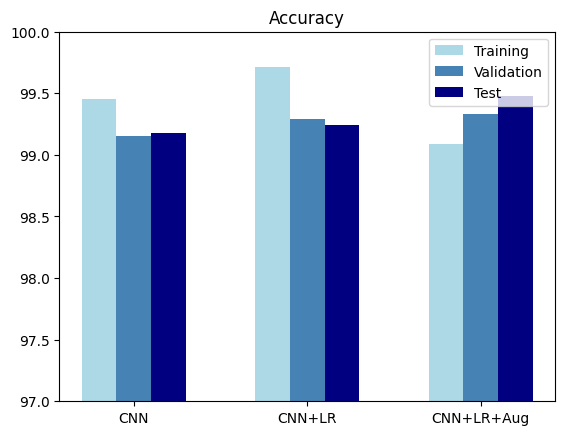

In [ ]:
#Create visual summary of performance for all three models

#Create lists of necessary data
models = [model0, model1, model2]
metrics = [model0_metrics, model1_metrics, model2_metrics]
names = ["Convolutional Neural Network", "CNN + Learning Rate Annealing", "CNN + LR + Data Augmentation"]

#Initiate an empty list to store the results
data = []

#Iterate and collect the performance summary data
for i, m in enumerate(zip(names, metrics, models)):
    data.append([m[0], "{:0.2f}".format(m[1].history["accuracy"][-1]*100), "{:0.2f}".format(m[1].history["val_accuracy"][-1]*100), "{:0.2f}".format(m[2].evaluate(X_test, y_test, verbose=0)[1]*100)])

#Add the results data to a dataframe and print it
results = pd.DataFrame(data, columns=("Model","Training Accuracy","Validation Accuracy", "Test Accuracy"))
display(results)

#Create a bar chart to compare the accuracy of all three models
plt.bar(np.arange(len(results["Model"].values)), results["Training Accuracy"].values.astype("float64"), 0.2, color="lightblue")
plt.bar(np.arange(len(results["Model"].values))+0.2, results["Validation Accuracy"].values.astype("float64"), 0.2, color="steelblue")
plt.bar(np.arange(len(results["Model"].values))+0.4, results["Test Accuracy"].values.astype("float64"), 0.2, color="navy")
plt.ylim(97, 100)
plt.xticks(np.arange(len(results["Model"].values))+0.2, ["CNN","CNN+LR", "CNN+LR+Aug"])
plt.legend(["Training","Validation", "Test"])

plt.title("Accuracy")